# Missing Data

This notebook discusses various approaches for dealing with missing data, and technical implementations for them.

For more details on Pandas' storage and routines for missing data, see “[Working with missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)” in the Pandas user guide.

What we do with missing data depends on two things:

- The meaning and source of the missingness
- The purpose of the analysis

Remember that our goal in this class is to use data to provide insight into questions.  Therefore, the guiding consideration for how to deal with missing data must be: what approach yields the most robust insight into my question in this context?

There are two broad approaches we can take to missing data:

1. Exclude it
2. Fill it in with a value

Both have their downsides, and there are many options within each.  There is not a one-size-fits-all rule, except that blanket whole-data-source approaches that don't flow from an understanding of the data and the questions are almost certainly wrong.

**Do not** just call `dropna` or `fillna` or run scikit-learn's `SimpleImputer` on your whole data frame to make the missing values go away, particularly without understanding the data distribution and its relationship to your analysis goals.

**Always** look at your data and think about it.

This notebook demonstrates two things:

* Looking at the data to understand missingness, and *removing* values that are actually missing
* Dealing with missing data in a variety of situations

**Rule:** for the purposes of dealing with missing data, cleanliness or completeness is usually *not* a property of the data *itself*.  It is better to think from our question, and how we want to handle missing data *for that question*.  The answer may not be the same for all questions in an analysis!

## About Missing Data

Many data sources do not have complete data — some observations are missing values for one or more variables.  Data can be missing for a variety of reasons:

- The instance does not have the property being measured
- The property wasn't measurable
- There was a measurement failure (e.g. a temperature sensor failed)
- The data has been lost or corrupted during transmission

Dealing with missing data is often considered part of data cleaning, that we'll talk more about in a later week, but some of it we need to be able to do quickly.  Further, I argue in this notebook that that really isn't the best way to think of it, but rather it is a part of our *analysis*: how does the analysis handle missing data?

But first, we need to talk about how it's stored and represented.

### Representing Missing Data

There are a variety of ways to represent missing data in an input file.  The Pandas `read_csv` function automatically detects missing data in CSV (and TSV) files in a variety of representations, including:

- Empty field
- NA
- NaN
- NULL

When we read the HETREC data in the other notebooks, we specifically specify the `na_values=["\\N"]` option because HETREC represents missing data with the string `\N` (we need the second backslash to escape it).  This is the notation PostgreSQL's `COPY` command uses in its default format when emitting `NULL` values from the database.

Some data sources also record missing data with a numeric value, in which case Pandas will *not* think it is missing.  Sometimes this is 0; sometimes it is a value with a much larger magnitude that expected actual values, such as 99 or -99999.  When *storing* data, I strongly recommend storing it as missing instead of an out-of-range numeric value, for two reasons: so the data actually looks like it is missing when it is loaded, and to eliminate risk of the missing-value sentinel accidentally being a legitimate value.  Storing missing data as 0 is particularly problematic, because 0 may well be a legitimate value, or close to a legitimate value.

Once the data is loaded into Pandas, missing data is represented in two primary ways:

- In `object` fields, it is `None`
- In `float64` (and `float32` fields), the IEEE floating point value 'Not a Number' (NaN)

Integer-based types *cannot* represent missing data. This is one reason why an integer column may be read as a float — Pandas finds missing values and needs to store them, so its default is to load as a float.  This is usually fine, as a 64-bit floating-point number can accurately represent any integer up to $2^{53} - 1$.  There is an `Int64` type (distinct from `int64`) that stores integers with an additional mask that indicates if the value is present or not, if you truly need 64-bit integers with missing data.

One other quick note: `NaN` is *weird*.  Any operation performed on it returns `NaN` (`NaN * 5` is `NaN`).  But also, it is not equal to anything, *including itself* (`NaN == NaN` is `False`).  In order to test for missingness, you need to use the Pandas `.isnull` method (checks for NaN or whatever value is used for 'missing' for the data in question), or the `np.isnan` function from NumPy (which checks numeric arrays for `NaN`).

### The Meaning of Missing Data

Conceptually, when a value is missing, there are two *different* possibilities for the meaning of this missingness:

- We know that there is no value
- We do not know the value, including possibly whether there is a value

Consider the variable “wheel size” for a vehicle.  The wheel size might be missing for a couple of reasons:

- We don't have a measurement of the wheel size for a particular car. It has a wheel size — cars have wheels — but we don't know what this particular car's wheel size is.
- Our vehicle table includes some observations of hovercraft, which have no wheels and therefore have no wheel size.

Sometimes, we may encode these differently — e.g. unknown vs. not applicable — or we may have two columns:

- *wheel size*
- *vehicle type*, *has_wheels*, or *wheel_count*, from which we can infer whether or not wheel size is a meaningful variable for that vehicle

Note that if we have a *wheel_count*, it too may be missing, in which case we don't have quite enough info to interpret a missing wheel size.

When it comes to the actual code of dealing with missing data, there isn't a difference between these meanings of missingness, but it may make a difference when deciding which approach to take.

## Libraries and Data

So we can actually show code, let's import our Python libraries and some data.  I'll use the HETREC data set again that we've been using in the other notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies = pd.read_table('hetrec2011-ml/movies.dat', sep='\t', na_values=['\\N'], encoding='latin1')
movies = movies.set_index('id')
movies.head()

,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
id,,,,,,,,,,,,,,,,,,,,
1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9.0,73.0,73.0,0.0,100.0,8.5,17.0,17.0,0.0,100.0,3.7,102338.0,81.0,http://content7.flixster.com/movie/10/93/63/10...
2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28.0,13.0,15.0,46.0,5.8,5.0,2.0,3.0,40.0,3.2,44587.0,61.0,http://content8.flixster.com/movie/56/79/73/56...
3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36.0,24.0,12.0,66.0,7.0,6.0,5.0,1.0,83.0,3.2,10489.0,66.0,http://content6.flixster.com/movie/25/60/25602...
4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25.0,14.0,11.0,56.0,5.5,11.0,5.0,6.0,45.0,3.3,5666.0,79.0,http://content9.flixster.com/movie/10/94/17/10...
5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19.0,9.0,10.0,47.0,5.4,5.0,1.0,4.0,20.0,3.0,13761.0,64.0,http://content8.flixster.com/movie/25/54/25542...


In [3]:
ratings = pd.read_table('hetrec2011-ml/user_ratedmovies-timestamps.dat', sep='\t')
ratings.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


## Understanding Missing Data

One of the key things to know for dealing with missing data is to find out how much is actually missing.  The `count()` method does this:

In [4]:
movies.count()

title                     10197
imdbID                    10197
spanishTitle              10197
imdbPictureURL            10016
year                      10197
rtID                       9886
rtAllCriticsRating         9967
rtAllCriticsNumReviews     9967
rtAllCriticsNumFresh       9967
rtAllCriticsNumRotten      9967
rtAllCriticsScore          9967
rtTopCriticsRating         9967
rtTopCriticsNumReviews     9967
rtTopCriticsNumFresh       9967
rtTopCriticsNumRotten      9967
rtTopCriticsScore          9967
rtAudienceRating           9967
rtAudienceNumRatings       9967
rtAudienceScore            9967
rtPictureURL               9967
dtype: int64

Data in the real world is *messy*.  Why are there movies that don't have a RottenTomatoes ID, but do have values for the other RT fields?  But we're going to set that aside for a moment and look at another issue in the data.

### Dropping Invalid Values

In this data source, we actually don't have *enough* missing data.

How are all-critics ratings distribtued? Let's start at looking at the numeric statistics (after pulling out into a variable for convenience):

In [5]:
ac_rates = movies['rtAllCriticsRating']
ac_rates.describe()

count    9967.000000
mean        5.139300
std         2.598048
min         0.000000
25%         4.000000
50%         5.800000
75%         7.000000
max         9.600000
Name: rtAllCriticsRating, dtype: float64

And the histogram, to see the distribution visually:

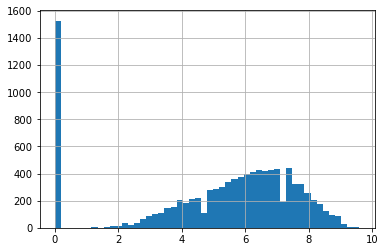

In [6]:
ac_rates.hist(bins=50)

We have minimum value of 0, but more interestingly, we have a *gap* between the 0s and the rest of the values. Starting at about 2, the values follow a relatively normal-looking distribution like we might expect for distributions of quality assessments, and 0 is a distinct bar.  That suggests that 0 is perhaps *qualitatively* different from the other values — perhaps when the data was collected, 0 was used when the critic rating score wasn't available?

Further, though, according to the [Rotten Tomatoes FAQ](https://www.rottentomatoes.com/faq), average ratings are based on taking the average of critic ratings, after mapping them to a 1–10 scale.  We don't have access to the FAQ as of when the HETREC data was crawled, but 1–10 is a common rating value.

If the average rating is the average of individual rating values in the range 1–10, is it possible for an actual average rating to have a value of 0?

Another thing we can do to illuminate this interpretation is to look at the distribution of ratings greater than 0:

In [7]:
ac_rates[ac_rates > 0].describe()

count    8441.000000
mean        6.068404
std         1.526898
min         1.200000
25%         5.000000
50%         6.200000
75%         7.200000
max         9.600000
Name: rtAllCriticsRating, dtype: float64

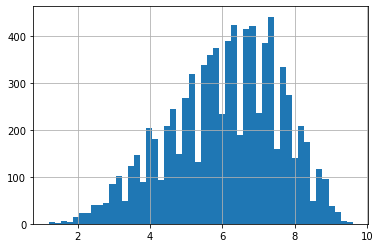

In [8]:
ac_rates[ac_rates > 0].hist(bins=50)

We have a large number of 0 values, and then the variable *jumps to 1.2*, and is relatively continuous above that.  This strong discontinuity is evidence of a qualitative difference - if it were an actual observed value of 0, we would expect quite a few 0.1, 0.2, etc., up to 1.2; actual observations are seldom that clustered on a single precise value, *particularly when the other observations are not*.

The documentation is the much more definitive source, but the distribution gives us insight that there is something distinctly, qualitatively different about 0, that suggests we should go looking in the docs. (Which we should do anyway.)

So let's consider average ratings of 0 to be missing, and do this for all the rating columns.  Pandas lets us bulk-set data (trick here: `.loc` can take a mask as the row argument, instead of an index key or list of index keys; this joint-accessor means 'the ratings column, at every row where the mask is `False`'; the mask is 'ratings column is 0'):

In [9]:
movies.loc[movies['rtAllCriticsRating'] == 0, 'rtAllCriticsRating'] = np.nan
movies['rtAllCriticsRating'].describe()

count    8441.000000
mean        6.068404
std         1.526898
min         1.200000
25%         5.000000
50%         6.200000
75%         7.200000
max         9.600000
Name: rtAllCriticsRating, dtype: float64

Now we have 8441 non-missing values, instead of the old 9.9K.  Let's do this for the other rating columns too:

In [10]:
movies.loc[movies['rtTopCriticsRating'] == 0, 'rtTopCriticsRating'] = np.nan
movies['rtTopCriticsRating'].describe()

count    4662.000000
mean        5.930330
std         1.534093
min         1.600000
25%         4.800000
50%         6.100000
75%         7.100000
max        10.000000
Name: rtTopCriticsRating, dtype: float64

In [11]:
movies.loc[movies['rtAudienceRating'] == 0, 'rtAudienceRating'] = np.nan
movies['rtAudienceRating'].describe()

count    7345.000000
mean        3.389258
std         0.454034
min         1.500000
25%         3.100000
50%         3.400000
75%         3.700000
max         5.000000
Name: rtAudienceRating, dtype: float64

It would be good to also try to understand missingness in the scores (% Fresh); the number of critics is going to be useful there, because if a movie has no critics, it can't have a score!  There it's harder though, because 0% Fresh is an actual, achievable score, and if a movie has only 1 critic, then it will either be 0% or 100% fresh depending on that critic's score!  So it's harder to figure out where the data we have should actually be missing.

That also isn't a problem we have to solve for our educational purposes of understanding what to do once we have missing data, so let's move forward.

### Actually Describing the Data

Now that we have made our rating values missing when they need to be, let's see how many we have.

The `describe` method, applied to a *data frame*, creates a data frame with the description statistics.  Let's do this:

In [12]:
rate_stats = movies[['rtAllCriticsRating', 'rtTopCriticsRating', 'rtAudienceRating']].describe()
rate_stats

,rtAllCriticsRating,rtTopCriticsRating,rtAudienceRating
count,8441.000000,4662.000000,7345.000000
mean,6.068404,5.930330,3.389258
std,1.526898,1.534093,0.454034
min,1.200000,1.600000,1.500000
25%,5.000000,4.800000,3.100000
50%,6.200000,6.100000,3.400000
75%,7.200000,7.100000,3.700000
max,9.600000,10.000000,5.000000


The `count` statistic tells us *how many* non-missing values there are.  Let's augument this with % missing - we're going to *transpose* the statistics frame (with `.transpose()`), and then create a column that divides count by the length of the original frame:

In [13]:
rate_stats = rate_stats.transpose()
rate_stats

,count,mean,std,min,25%,50%,75%,max
rtAllCriticsRating,8441.0,6.068404,1.526898,1.2,5.0,6.2,7.2,9.6
rtTopCriticsRating,4662.0,5.930330,1.534093,1.6,4.8,6.1,7.1,10.0
rtAudienceRating,7345.0,3.389258,0.454034,1.5,3.1,3.4,3.7,5.0


In [14]:
rate_stats['frac_observed'] = rate_stats['count'] / len(movies)
rate_stats

,count,mean,std,min,25%,50%,75%,max,frac_observed
rtAllCriticsRating,8441.0,6.068404,1.526898,1.2,5.0,6.2,7.2,9.6,0.827792
rtTopCriticsRating,4662.0,5.930330,1.534093,1.6,4.8,6.1,7.1,10.0,0.457193
rtAudienceRating,7345.0,3.389258,0.454034,1.5,3.1,3.4,3.7,5.0,0.720310


`frac_observed` means 'fraction observed', and is the fraction of observations for which we have observed a value for this variable, *after* all our cleaning earlier to get rid of the values that seemed to be present but were actually missing.

When we are describing a variable, it's good to know *two* things:

- how many of that variable we actually have
- how the values we have are distributed (middle, spread, min/max, and a histogram, usually)

## Ignoring Missing Values

One way to handle missing values is to just **ignore them**.  The Pandas aggregate functions, for example, will skip missing values by default.  So if you compute the mean critic rating:

In [15]:
movies['rtAllCriticsRating'].mean()

6.068404217509789

it is taking the mean *of the values we have*.  In particular, the missing values are *not* counted in the denominator.

We can tell it not to skip missing values, with the `skipna` option:

In [16]:
movies['rtAllCriticsRating'].mean(skipna=False)

nan

The result is NaN, because some values are missing, and adding NaN to a value results in NaN.  So the sum of values — the numerator of the mean — is NaN, and the final mean is NaN.  NaNs are infectious in floating-point operations: once you have one, it propagates through the rest of the computation.

Many of our plot types will also ignore missing values:

C:\Users\michaelekstrand\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michaelekstrand\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


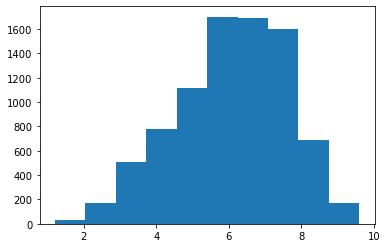

In [17]:
plt.hist(movies['rtAllCriticsRating'])
plt.show()

The scatter plot will ignore values for which *either* value is missing:

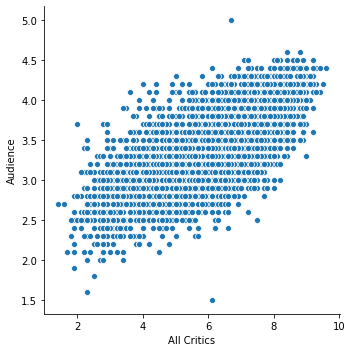

In [18]:
sns.relplot('rtAllCriticsRating', 'rtAudienceRating', data=movies)
plt.xlabel('All Critics')
plt.ylabel('Audience')
plt.show()

This is often fine: if we want to understand the mean rating, understanding the mean *of the data we have* is often appropriate.  This is an additional qualification to the question, but that is a part of the question refinement process.

Another way missing data can be ignored is in a group-by: if we group-by and we have missing data, ignoring those values just mean they don't contribute to any group.  If that does not seriously impact the validity of our analysis with respect to our goals and the meaning of the data, we're often fine!

If we are trying to understand how a variable differs between different groups of data points, and we don't know which group some of the points are in (we have missing data in our group categorical variable), we may well have enough other data points where we *do* know the value that we can reasonably understand the approximate differences between groups without that data point's contribution.

But, we don't want to just ignore the data without thinking or documenting the fact.  We should report the number and/or fraction observed, so that we have context to interpret the statistics we compute in the face of missing data.

One way in which ignoring missing data can be misleading is if the missing data would — if we knew it — have a different distribution than the observed data.  This is simultaneously common and difficult to address (or even reliably tell if it is happening).  There are usually two things we need to do in this case:

- analyze the data we have, and appropriately discuss the limitations of our analysis in the face of missing data
- try to get better data

In addition to dropping individual values, we can drop *entire observations* that have missing data.

## Filling Data

Another way to handle missing data is to *fill it in* with other value(s).

### Filling with a Fixed Value

The Pandas `fillna` method (applicable to both `Series` and `DataFrame`) fills in missing values with a specified value.

There are two cases when this is clearly appropriate.  The first is when we **know the value of the missing data**.  For example, if we count the number of ratings in our data set, and join that with the movies table:

In [19]:
movie_stats = ratings.groupby('movieID')['rating'].agg(['count', 'mean']).rename(columns={
    'count': 'mlNumRatings',
    'mean': 'mlAvgRating'
})
movie_info = movies.join(movie_stats)
movie_info['mlNumRatings'].describe()

count    10109.000000
mean        84.637254
std        172.115584
min          1.000000
25%          6.000000
50%         21.000000
75%         75.000000
max       1670.000000
Name: mlNumRatings, dtype: float64

There are few values missing!  If we have a movie that never appears in our movie ratings frame, we know that its number of rating is 0, so it is appropriate to fill in the missing values with 0:

In [20]:
movie_info['mlNumRatings'].fillna(0, inplace=True)
movie_info['mlNumRatings'].describe()

count    10197.000000
mean        83.906835
std        171.549962
min          0.000000
25%          6.000000
50%         20.000000
75%         73.000000
max       1670.000000
Name: mlNumRatings, dtype: float64

Now the missing values (all 88 of them) are filled in, and we have a minimum value of 0.

**Note:** we used the *inplace* version of the method, with `inplace=True`.  This modified the series in-place (in its place in the frame), instead of returning of a new series.

If a value is not a count of some kind, then it's unlikely that filling with 0 is the appropriate value.

The second case when filling missing data is clearly appropriate is when we are **filling with an unknown-data code**.  This is most common with categorical (or sometimes ordinal) data.  Sometimes this is a new code, and we are just treating 'unknown' as another category; in other times, there is already a code for 'unknown', and it's reasonable to treat all kinds of 'unknown' as the same.

In other cases, figuring out how to fill in the **data** in an abstract sense is usually not the best way to approach the problem.  Instead, think about how each specific analysis should handle missing data; if it is appropriate to fill in a value, the value may differ from one analysis to another!

For one immediate example, if we fill in missing ratings with 0, and then take the mean, that will bias the mean towards 0, beacuse there are so many (invalid) 0 values in the data.  We probably don't want that!

### Filling with Another Series

Sometimes, we have two series of data, and we want to treat series *B* as a fallback for series *A*: use data from series A if we can, and if not, use B (if neither has the data, it will remain missing).

The Pandas `combine_first` method does exactly this.  The code

    seriesA.combine_first(seriesB)
    
will use values from `seriesA` when available, and try to fill in missing values with data from `seriesB`.  Both series need to have the same index.

For example, if we want to use top-critics ratings first, but if they aren't available, fall back to all-critics ratings, we could:

In [21]:
merge_rates = movies['rtTopCriticsRating'].combine_first(movies['rtAllCriticsRating'])
merge_rates.describe()

count    8441.000000
mean        6.016420
std         1.547711
min         1.200000
25%         4.900000
50%         6.200000
75%         7.200000
max        10.000000
Name: rtTopCriticsRating, dtype: float64

### Imputing Values

*Imputation* fills in missing values with a result of some computation.  In its simplest form, it is technically the same as filling with a single value: for example, we may assume that missing values are equal to the mean of the other values in the column.  We may do more sophisticated imputation, trying to predict the missing data from other variables in the observation.

The [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) algorithm from scikit-learn will perform simple imputations of features, such as a mean value.  Other imputation strategies can perform more sophisticated analysis.

The challenge with imputation is that the validity of the resulting inferences relies on the validity and accuracy of the imputation strategy.  It can be useful as a part of feature engineering for a machine learning pipeline, where we primarily care about the system's ability to predict future values of the outcome or ttarget  variable.

However, when our goal is to understand the data, make observations, and learn things from it, imputation usually impedes that goal, because we are no longer just observing and interpreting the data, but also the results of an imputation process.

### Think About the Analysis

I said at the top of the notebook, and will reiterate in the conclusion, that our missing-data decisions need to **flow from the questions**, and the analysis.

One specific way this manifests is that the choice of value to fill depends in large part on how we want missing data to affect our final computation.  For using the variable as a feature in a machine learning pipeline, either a simple linear model or something more sophisticated, imputing the mean is often *mathematically* equivalent to ignoring the value for that observation, because the model will learn how to respond to a variable *as it differes from the mean*; the mean will result in a 'default' behavior.  In particular, it's common good practice to *standardize* our variables prior to such analyses by subtracting the mean from the observed values so they have a mean of zero; when we do this, there is no difference between filling in the mean first, and filling the missing standardized values with zero, and filling with zero before applying a linear model will cause the missing values to have no effect on their observations' predictions.

This will become clearer when we get to linear models.  But other types of models may have other responses to different values, and we should choose our handling of the missing data based on how it will influence the analysis results, and whether that is the influence we want it to have.

## Conclusion

There are several ways we can handle missing data in an analysis.  In this notebook, I have argued that we should approach the problem based on the influence missing data should have on our final analysis, rather than treating it as a problem to be solved at the data level.

We have, broadly speaking, two tools for dealing with missing data:

- Ignore it (either the individual value, or the entire observation)
- Fill in a suitable default or assumed value

In a few cases, there is a reasonable and clear choice from the data itself.  But in general, the fundamental question guiding what we do with missing data is this: “how should an observation with missing value(s) be reflected in my analysis?”.  The answer to this question will differ between one analysis and another.

There are a few principles that are general good practice, however:

- Describe the missingness of the data — how many values are missing, and what fraction of the observations are they?
- If helpful, look at whether other features of the data differ between instances with missing values for a variable and those with known values.  This can help shed light on whether the missing data has a systematically different distribution than the observed data, and what impact that may have on your final analysis.
- Bind missing-data operations to the *analysis*, not to the data load and pre-processing stages.  If you need to compute the mean of a series, treating missing values as 5 for some well-defined reason, put the `fillna` *with the other operation* in the analysis.  Think of it, and describe it, as the operation "compute the mean of the series, assuming missing values are 5", rather than "compute the mean of this variable, that we have filled with 5s for unrelated reasons".  This will make it easier for you to reason about the correctness and appropriateness of how you handle the missing data in the context of specific analyses and computations.
- Use analyses that can deal with missing data when practical, instead of needing to pretend it isn't missing.

Sometimes, you will do several analyses with the same missing-data transformation of the variable.  In these cases, it can be reasonable to do this transformation where you are loading and cleaning up the data, but describe and justify the transformation in terms of the analysis you are performing and its correctness for having the desired effects on that analysis.  Also, consider defining a *new* variable that is “old variable with this missing data operation performed” instead of just cleaning the old variable.

At the end of the day, our missing data treatment — like all other aspects of our analysis — needs to flow from our analysis goals and research questions, and we need to defend it on the basis of how it will impact the conclusions we draw.